In [ ]:
import os
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D



In [ ]:
from google.colab import files
files.upload()  # select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namrahkhandurrani","key":"837302267d31f2c297ca141ed2967d15"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 98% 1.19G/1.21G [00:06<00:00, 175MB/s]
100% 1.21G/1.21G [00:08<00:00, 150MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("gtzan-dataset-music-genre-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("gtzan_data")

##Approach A — Tabular (MFCC Features)
Step 1: Feature Extraction (Librosa)

In [ ]:
import soundfile as sf
import glob

for file in glob.glob('./gtzan_data/Data/genres_original/*/*.wav'):
    try:
        sf.info(file)
    except:
        print("Corrupted file:", file)


Corrupted file: ./gtzan_data/Data/genres_original/jazz/jazz.00054.wav


In [ ]:
!rm ./gtzan_data/Data/genres_original/jazz/jazz.00054.wav


In [ ]:
import librosa
import numpy as np
import os
import pandas as pd

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
data = []

for genre in genres:
    folder = f'./gtzan_data/Data/genres_original/{genre}'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            y, sr = librosa.load(file_path, duration=30)
            mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
            spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)

            features = np.hstack([mfcc, chroma, spectral_contrast])
            data.append([*features, genre])

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

columns = [f'mfcc{i+1}' for i in range(20)] + [f'chroma{i+1}' for i in range(12)] + [f'contrast{i+1}' for i in range(7)] + ['genre']
df = pd.DataFrame(data, columns=columns)


Step 2: Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('genre', axis=1)
y = LabelEncoder().fit_transform(df['genre'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


Step 3: Train Machine Learning Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.575
              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.58      0.92      0.71        12
           2       0.62      0.75      0.68        24
           3       0.55      0.50      0.52        22
           4       0.32      0.47      0.38        15
           5       0.63      0.44      0.52        27
           6       0.76      0.89      0.82        18
           7       0.65      0.68      0.67        19
           8       0.39      0.41      0.40        22
           9       0.50      0.25      0.33        20

    accuracy                           0.57       200
   macro avg       0.58      0.59      0.57       200
weighted avg       0.58      0.57      0.57       200



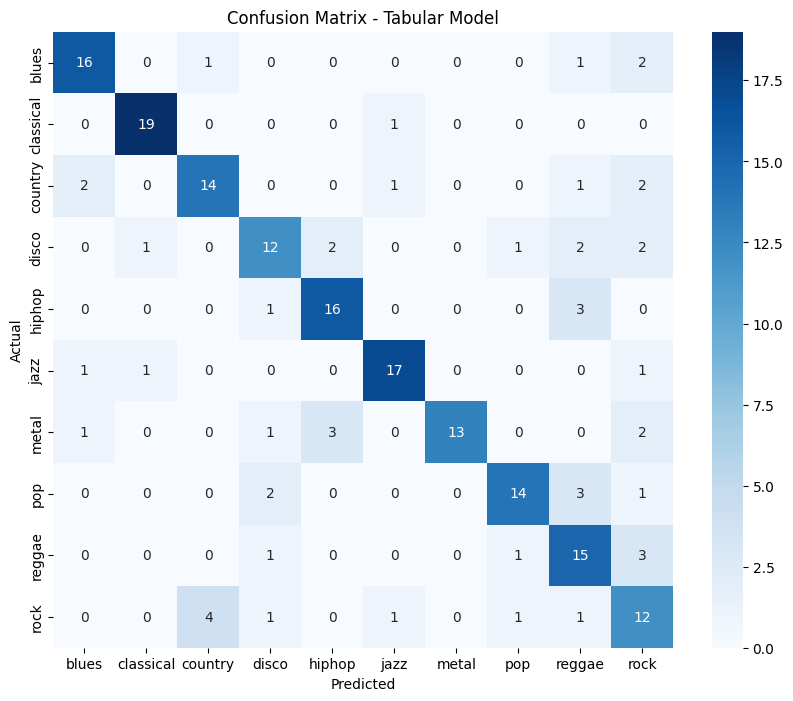

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genres,
            yticklabels=genres)
plt.title('Confusion Matrix - Tabular Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Approach B — Image-based (Mel Spectrogram CNN)
Step 1: Convert Audio → Mel-Spectrogram Images

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import os

save_dir = './spectrograms'

for genre in genres:
    os.makedirs(f'{save_dir}/{genre}', exist_ok=True)
    folder = f'./gtzan_data/Data/genres_original/{genre}' # Corrected path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        # Add a check to skip files that are not .wav
        if file_path.endswith('.wav'):
            try:
                y, sr = librosa.load(file_path, duration=30)
                mel = librosa.feature.melspectrogram(y=y, sr=sr)
                mel_db = librosa.power_to_db(mel, ref=np.max)

                plt.figure(figsize=(2.24, 2.24))  # 224x224 for CNN input
                librosa.display.specshow(mel_db, sr=sr, cmap='magma')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(f'{save_dir}/{genre}/{filename[:-4]}.png', bbox_inches='tight', pad_inches=0)
                plt.close()
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

Step 2: Train CNN (From Scratch)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)


train_data = datagen.flow_from_directory(
    save_dir, target_size=(224,224), batch_size=32, subset='training'
)
val_data = datagen.flow_from_directory(
    save_dir, target_size=(224,224), batch_size=32, subset='validation'
)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=15)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1444 - loss: 935.3671 - val_accuracy: 0.2010 - val_loss: 2.1885
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.2467 - loss: 2.1049 - val_accuracy: 0.2714 - val_loss: 2.1258
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3406 - loss: 1.8352 - val_accuracy: 0.3166 - val_loss: 2.0380
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5477 - loss: 1.2760 - val_accuracy: 0.4171 - val_loss: 1.9953
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7202 - loss: 0.8285 - val_accuracy: 0.4020 - val_loss: 1.9570
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8120 - loss: 0.5722 - val_accuracy: 0.3467 - val_loss: 2.3002
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8793 - loss: 0.3940 - val_accuracy: 0.3467 - val_loss: 2.5382
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9085 - loss: 0.2949 - val_accuracy: 0.3618 - val_los

Step 3: Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet = model.fit(train_data, validation_data=val_data, epochs=10)

# Save the ResNet50 model
model.save("resnet50_music_genre_model.h5")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.1030 - loss: 2.4155 - val_accuracy: 0.1005 - val_loss: 2.3175
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.0970 - loss: 2.3324 - val_accuracy: 0.1005 - val_loss: 2.3011
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.0919 - loss: 2.3083 - val_accuracy: 0.1106 - val_loss: 2.2991
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.1024 - loss: 2.3061 - val_accuracy: 0.2060 - val_loss: 2.2984
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.1121 - loss: 2.3037 - val_accuracy: 0.1005 - val_loss: 2.3005
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.0922 - loss: 2.3009 - val_accuracy: 0.0201 - val_loss: 2.3003
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - accuracy: 0.1021 - loss: 2.3014 - val_accuracy: 0.1005 - val_loss: 2.3000
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.1005 - loss: 2.3001 - val_accuracy: 0.0452 - v

Visulization

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - accuracy: 0.3774 - loss: 2.9086
CNN Accuracy: 0.39


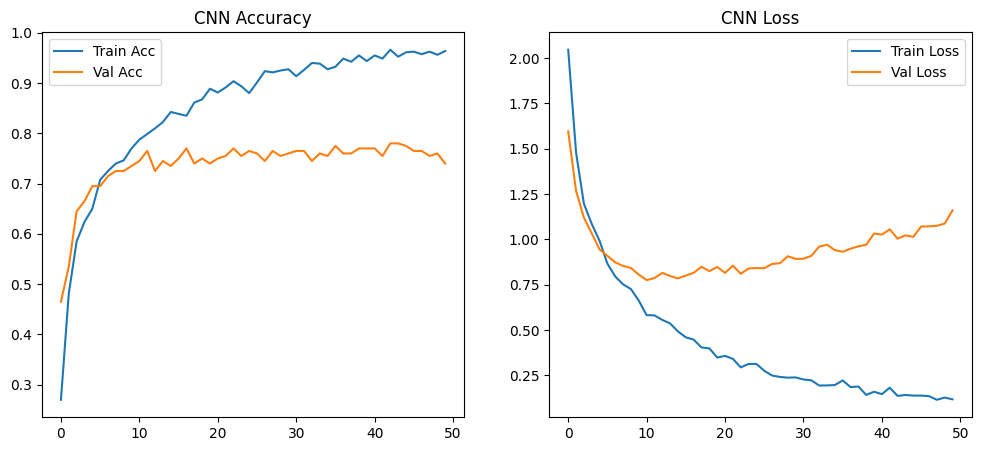

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"CNN Accuracy: {val_acc:.2f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('CNN Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('CNN Loss')
plt.show()

In [ ]:
resnet_loss, resnet_acc = model.evaluate(val_data)
print(f"ResNet50 Accuracy: {resnet_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.4505 - loss: 2.6402
ResNet50 Accuracy: 0.39
